# Tail Bout Classification

**In this notebook, we will walk through the process of classifying tail bouts.**


* Loading dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from megabouts.tracking_data import TrackingConfig, load_example_data, FullTrackingData
from megabouts.config import TailPreprocessingConfig, TrajPreprocessingConfig
from megabouts.preprocessing import TailPreprocessing, TrajPreprocessing
from megabouts.config import TailSegmentationConfig
from megabouts.segmentation import Segmentation, align_traj_array
from megabouts.classification import TailBouts, BoutClassifier
from megabouts.utils import bouts_category_color, bouts_category_name_short

* Check if pytorch is running on cpu or gpu:

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


* Loading tracking data and preprocessing similar to [tutorial_Tail_Preprocessing](./tutorial_Tail_Preprocessing.ipynb) and [tutorial_Traj_Preprocessing](./tutorial_Traj_Preprocessing.ipynb)

In [3]:
df_recording, fps, mm_per_unit = load_example_data("fulltracking_posture")

tracking_cfg = TrackingConfig(fps=fps, tracking="full_tracking")

head_x = df_recording["head_x"].values * mm_per_unit
head_y = df_recording["head_y"].values * mm_per_unit
head_yaw = df_recording["head_angle"].values
tail_angle = df_recording.filter(like="tail_angle").values

tracking_data = FullTrackingData.from_posture(
    head_x=head_x, head_y=head_y, head_yaw=head_yaw, tail_angle=tail_angle
)

tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps)
tail_df_input = tracking_data.tail_df
tail = TailPreprocessing(tail_preprocessing_cfg).preprocess_tail_df(tail_df_input)

traj_preprocessing_cfg = TrajPreprocessingConfig(fps=tracking_cfg.fps)
traj_df_input = tracking_data.traj_df
traj = TrajPreprocessing(traj_preprocessing_cfg).preprocess_traj_df(traj_df_input)

In [4]:
tail.df.head(5)

angle                                                              \
   segments                                                               
          0         1         2         3         4         5         6   
0 -0.101865 -0.092813 -0.107645 -0.110575 -0.047699 -0.145887 -0.130414   
1 -0.082618 -0.087957 -0.096951 -0.092459 -0.119418 -0.043354 -0.099788   
2 -0.093377 -0.095235 -0.094292 -0.105936 -0.073785 -0.084193 -0.144378   
3 -0.092590 -0.083650 -0.100938 -0.088223 -0.097370 -0.099559 -0.101538   
4 -0.086849 -0.081982 -0.096705 -0.118475 -0.046264 -0.136459 -0.115412   

                           ... angle_smooth                                \
                           ...     segments                                 
          7         8   9  ...            2         3         4         5   
0 -0.058892 -0.128705 NaN  ...    -0.051057 -0.055168 -0.055898 -0.061701   
1 -0.101741 -0.171555 NaN  ...    -0.046070 -0.052906 -0.056578 -0.063577   
2 -0.112398 -0.042585 NaN  ...    -0.041909 -0.050905 -0.056916 -0.064832   
3 -0.091272 -0.021459 NaN  ...    -0.038574 -0.049166 -0.056913 -0.065467   
4 -0.085300 -0.015487 NaN  ...    -0.036064 -0.047688 -0.056569 -0.065483   

                                          vigor no_tracking  
                                                             
          6         7         8         9                    
0 -0.061091 -0.069420 -0.115014  0.000183   NaN        True  
1 -0.062286 -0.064780 -0.091617  0.000321   NaN        True  
2 -0.062943 -0.060658 -0.072246  0.000430   NaN        True  
3 -0.063063 -0.057053 -0.056900  0.000512   NaN        True  
4 -0.062646 -0.053965 -0.045579  0.000565   NaN        True  

[5 rows x 32 columns]

## Segmentation using tail vigor

* Set the threshold to 20 and apply segmentation to `tail.vigor`:

In [5]:
tail_segmentation_cfg = TailSegmentationConfig(fps=tracking_cfg.fps, threshold=20)
segmentation_function = Segmentation.from_config(tail_segmentation_cfg)
segments = segmentation_function.segment(tail.vigor)

* We collect the segmented bouts using `extract_tail_array`  and `extract_traj_array`:

In [6]:
tail_array = segments.extract_tail_array(tail_angle=tail.angle_smooth)
traj_array = segments.extract_traj_array(
    head_x=traj.x_smooth, head_y=traj.y_smooth, head_angle=traj.yaw_smooth
)

The arrays contain tail and trajectory data aligned to bout onset:
- `tail_array`: Tail angles for each bout (shape: n_bouts × n_segments × n_timepoints)
- `traj_array`: Trajectory data for each bout (shape: n_bouts × 3 × n_timepoints). The 3 dimensions are: x position, y position, and heading angle


In [7]:
print(tail_array.shape, traj_array.shape)

(766, 10, 140) (766, 3, 140)


* Optional: Align trajectory data for pre-segmented bouts:


In [8]:
"""
If you're loading pre-segmented data instead of using the segmentation pipeline above,
you'll need to align the trajectory data to the bout onset. This ensures all bouts
are properly oriented relative to their starting position and heading.
"""

# Align trajectory data relative to bout onset
traj_array = align_traj_array(
    traj_array=traj_array,
    idx_ref=0,  # Align to bout onset
    bout_duration=tail_segmentation_cfg.bout_duration,
)

## Running classifier on the segmented bouts

* Load the classifier, we recommend using `exclude_CS=True`. This will avoid assigning bouts to Capture Swim categories if there was no prey during the recording:

In [9]:
classifier = BoutClassifier(tracking_cfg, tail_segmentation_cfg, exclude_CS=True)

E:\Code\megabouts\megabouts\megabouts\classification\classification.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(transformer_weights_path, map_location=t

* Apply the classfier:

In [10]:
classif_results = classifier.run_classification(
    tail_array=tail_array, traj_array=traj_array
)

* Now we re-segment the bouts using the first half beat as a reference, this improves the alignement of the tail bouts, for this we use the `align_to_onset=False` option:

In [11]:
segments.set_HB1(classif_results["first_half_beat"])

tail_array = segments.extract_tail_array(
    tail_angle=tail.angle_smooth, align_to_onset=False
)

traj_array = segments.extract_traj_array(
    head_x=traj.x_smooth,
    head_y=traj.y_smooth,
    head_angle=traj.yaw_smooth,
    align_to_onset=False,
)

* We can use the TailBouts class to store the results of the classifier:

In [12]:
# Format Output:
bouts = TailBouts(
    segments=segments,
    classif_results=classif_results,
    tail_array=tail_array,
    traj_array=traj_array,
)

* Let's display the bouts classified, we only display bouts with a classification probability greater than 0.5:

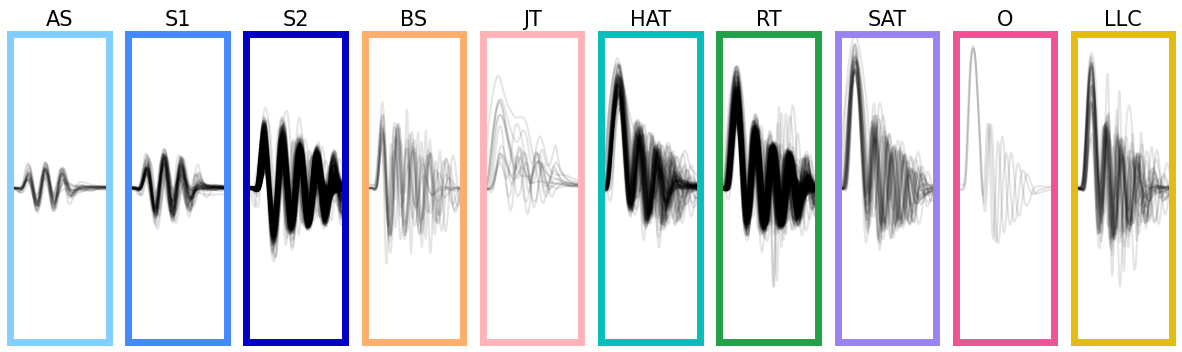

In [13]:
id_b = np.unique(bouts.df.label.category[bouts.df.label.proba > 0.5]).astype("int")

fig, ax = plt.subplots(facecolor="white", figsize=(15, 4))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
G = gridspec.GridSpec(1, len(id_b))
ax0 = {}
for i, b in enumerate(id_b):
    ax0 = plt.subplot(G[i])
    ax0.set_title(bouts_category_name_short[b], fontsize=15)
    for i_sg, sg in enumerate([1, -1]):
        id = bouts.df[
            (bouts.df.label.category == b)
            & (bouts.df.label.sign == sg)
            & (bouts.df.label.proba > 0.5)
        ].index
        if len(id) > 0:
            ax0.plot(sg * bouts.tail[id, 7, :].T, color="k", alpha=0.1)
        ax0.set_xlim(0, tail_segmentation_cfg.bout_duration)
        ax0.set_ylim(-4, 4)
        ax0.set_xticks([])
        ax0.set_yticks([])
        for sp in ["top", "bottom", "left", "right"]:
            ax0.spines[sp].set_color(bouts_category_color[b])
            ax0.spines[sp].set_linewidth(5)
plt.show()